In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [ ]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train_mu = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = x_train/255
x_test = x_test/255

x_train = x_train.reshape(len(x_train), 1, 28, 28)
x_test = x_test.reshape(len(x_test),1, 28, 28)

In [ ]:
device = 'cpu'
if torch.cuda.is_available() :
  device = 'cuda'

In [ ]:
def display_images_grid(images, rows, cols):
    """
    Displays multiple images in a grid.

    Args:
        images: A list of image data (e.g., NumPy arrays).
        rows: Number of rows in the grid.
        cols: Number of columns in the grid.
    """

    fig, axs = plt.subplots(rows, cols, figsize=(6, 4))  # Adjust figure size as needed

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(images):
                axs[i, j].imshow(images[index], cmap = 'gray')
                axs[i, j].axis('off')  # Turn off axis labels for cleaner display
            else:
                axs[i, j].axis('off')  # Hide empty subplots

    plt.tight_layout()  # Adjust spacing between subplots for better layout
    plt.show()

In [ ]:
def squeeze_image(x) :
  B, C, H, W = x.shape
  assert H % 2 == 0
  assert W % 2 == 0

  new_x = []
  for i in range(H//2) :
    h_start_now = i*2
    h_end_now = (i+1)*2

    new_row = []
    for j in range(W//2) :
      w_start_now = j*2
      w_end_now = (j+1)*2

      row_now = x[:,:,h_start_now:h_end_now, w_start_now:w_end_now]
      row_now = row_now.reshape(B,-1)
      new_row.append(row_now)
    new_row = torch.stack(new_row, -1) # B x C x 1 x W
    new_x.append(new_row)
  new_x = torch.stack(new_x, -2)

  return new_x

def unsqueeze_image(x) :
  B, C, H, W = x.shape
  assert C % 4 == 0

  new_x = []
  for i in range(H) :
    new_row = []
    for j in range(W) :
      row_now = x[:,:,i, j].reshape(B, C//4, 2, 2)
      new_row.append(row_now)

    temp_new_row = new_row[0]
    for j in range(len(new_row) - 1) :
      temp_new_row = torch.cat((temp_new_row, new_row[j+1]), -1)
    new_row = temp_new_row

    new_x.append(new_row)

  temp_new_X = new_x[0]
  for i in range(H - 1) :
    temp_new_X = torch.cat((temp_new_X,new_x[i + 1] ), -2)
  new_x = temp_new_X

  return new_x


In [ ]:
temp_input = torch.randn(1,1,6,6)
temp_output = squeeze_image(temp_input)
temp_recon = unsqueeze_image(temp_output)
torch.mean(abs(temp_input- temp_recon))

tensor(0.)

In [ ]:
temp_input[0]

tensor([[[-0.8139,  1.2320, -0.7545,  0.1818,  0.2710, -0.8163],
         [ 0.1531,  1.0927,  0.3061,  0.5063, -0.0129,  1.0243],
         [-1.3213, -0.4141,  1.5522, -0.8501, -1.7184, -1.1061],
         [ 0.3980,  0.3107, -0.3142, -0.7012,  0.5230, -0.6067],
         [ 0.3832, -0.8662,  0.1754, -1.1225, -0.6510, -2.2807],
         [-0.0944,  0.5798,  0.8885,  0.4158,  0.5129,  0.7610]]])

In [ ]:
temp_output[0][:,0,0]

tensor([-0.8139,  1.2320,  0.1531,  1.0927])

In [ ]:
class MyConvNeuralNet(nn.Module) :
  def __init__(self, in_dim, hidden_dim) :
    super(MyConvNeuralNet, self).__init__()
    self.linear1 = nn.Conv2d(in_dim, hidden_dim, (3,3), padding=(1,1))
    self.norm1 = nn.InstanceNorm2d(hidden_dim)
    self.linear2 = nn.Conv2d(hidden_dim, hidden_dim, (1,1))
    self.norm2 = nn.InstanceNorm2d(hidden_dim)
    self.linear3 = nn.Conv2d(hidden_dim, in_dim, (3,3), padding=(1,1))
    self.linear3.weight = nn.Parameter(torch.zeros_like(self.linear3.weight ))
    self.linear3.bias = nn.Parameter(torch.zeros_like(self.linear3.bias ))

  def forward(self, x) :
    yhat = self.linear1(x)
    yhat = self.norm1(yhat)
    yhat = torch.relu(yhat)

    yhat = self.linear2(yhat)
    yhat = self.norm2(yhat)
    yhat = torch.relu(yhat)

    yhat = self.linear3(yhat)

    return yhat

In [ ]:
class AffineCouplingLayer(nn.Module) :
  def __init__(self, input_channel , model_channel) :
    super(AffineCouplingLayer, self).__init__()
    self.nn_log_s = MyConvNeuralNet(input_channel//2, model_channel)
    self.nn_t = MyConvNeuralNet(input_channel//2, model_channel)

  def forward(self, x) :
    # assume input is B x C x H x W
    # output is (y, log-det)
    assert len(x.shape) == 4
    assert x.shape[1] % 2 == 0

    half_dim = x.shape[1] // 2
    xa, xb = x[:, :half_dim], x[:, half_dim:]
    log_s, t = self.nn_log_s(xb), self.nn_t(xb)
    s = torch.exp(log_s)
    ya = s*xa + t
    yb = xb
    y = torch.cat((ya,yb), 1)

    return y, torch.mean(log_s)


  def inverse_forward(self, y) :
    # assume input is B X D, with D % 2 = 0
    assert len(y.shape) == 4
    assert y.shape[1] % 2 == 0

    half_dim = y.shape[1] // 2
    ya, yb = y[:, :half_dim], y[:, half_dim:]
    log_s, t = self.nn_log_s(yb), self.nn_t(yb)
    s = torch.exp(log_s)
    xa = (ya - t)/s
    xb = yb
    x = torch.cat((xa,xb), 1)

    return x

In [ ]:
def create_permute_matrix(model_dim) :
  arange_num = np.arange(model_dim)
  np.random.shuffle(arange_num)
  permute_matrix = np.zeros((model_dim, model_dim))
  permute_matrix[np.arange(model_dim), arange_num] = 1
  permute_matrix = torch.as_tensor(permute_matrix).float()
  inv_permute_matrix = torch.as_tensor(np.linalg.inv(permute_matrix)).float()

  return permute_matrix, inv_permute_matrix

def apply_permute(img_now, permute_matrix) :
  img_now = img_now.permute(0,2,3,1)
  img_now = img_now @ permute_matrix
  img_now = img_now.permute(0,3,1,2)
  return img_now


class MyModel(nn.Module) :
  def __init__(self, model_dim) :
    super(MyModel, self).__init__()
    self.epsilon = torch.as_tensor(1e-6).float()
    self.num_layers_block = 6

    self.block1 = nn.ModuleList([AffineCouplingLayer(4,model_dim) for i in range(self.num_layers_block)])
    self.permute_block1, self.inv_permute_block1 = create_permute_matrix(4)
    self.permute_block1 = self.permute_block1.to(device)
    self.inv_permute_block1 = self.inv_permute_block1.to(device)

    self.block2 = nn.ModuleList([AffineCouplingLayer(16,model_dim*4) for i in range(self.num_layers_block)])
    self.permute_block2, self.inv_permute_block2 = create_permute_matrix(16)
    self.permute_block2 = self.permute_block2.to(device)
    self.inv_permute_block2 = self.inv_permute_block2.to(device)


    self.last_layer = AffineCouplingLayer(16,model_dim*4)



  def forward(self,x) :
    total_log_det = 0
    yhat = -torch.log(1/(torch.minimum(torch.maximum(x, self.epsilon),1 - self.epsilon)) - 1)

    yhat = squeeze_image(yhat)
    for layer_now_idx in range(len(self.block1)) :
      layer_now = self.block1[layer_now_idx]
      yhat, log_s_now = layer_now(yhat)
      total_log_det = total_log_det + log_s_now
      yhat = apply_permute(yhat, self.permute_block1)

    yhat = squeeze_image(yhat)
    for layer_now_idx in range(len(self.block2)) :
      layer_now = self.block2[layer_now_idx]
      yhat, log_s_now = layer_now(yhat)
      total_log_det = total_log_det + log_s_now
      yhat = apply_permute(yhat, self.permute_block2)


    yhat, log_s_now = self.last_layer(yhat)
    total_log_det = total_log_det + log_s_now


    return yhat, total_log_det

  def inverse_forward(self,y) :
    xhat = self.last_layer.inverse_forward(y)

    for layer_now_idx in range(len(self.block2)) :
      layer_now = self.block2[len(self.block2) - layer_now_idx - 1]

      xhat = apply_permute(xhat, self.inv_permute_block2)
      xhat = layer_now.inverse_forward(xhat)
    xhat = unsqueeze_image(xhat)


    for layer_now_idx in range(len(self.block1)) :
      layer_now = self.block1[len(self.block1) - layer_now_idx - 1]

      xhat = apply_permute(xhat, self.inv_permute_block1)
      xhat = layer_now.inverse_forward(xhat)
    xhat = unsqueeze_image(xhat)


    xhat = 1/(1 + torch.exp(-xhat))

    return xhat


In [ ]:
model = MyModel(320)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(), 1e-4)

temp_x = torch.as_tensor(x_train[0:1]).float().to(device)
temp_output, log_det_now = model(temp_x)
temp_inv = model.inverse_forward(temp_output)


0 tensor(-0.3907, device='cuda:0', grad_fn=<SubBackward0>)
10 tensor(-0.1396, device='cuda:0', grad_fn=<SubBackward0>)
20 tensor(-0.2778, device='cuda:0', grad_fn=<SubBackward0>)
30 tensor(-0.2465, device='cuda:0', grad_fn=<SubBackward0>)
40 tensor(-0.2810, device='cuda:0', grad_fn=<SubBackward0>)
50 tensor(-0.2185, device='cuda:0', grad_fn=<SubBackward0>)
60 tensor(-0.3204, device='cuda:0', grad_fn=<SubBackward0>)
70 tensor(-0.3656, device='cuda:0', grad_fn=<SubBackward0>)
80 tensor(-0.2319, device='cuda:0', grad_fn=<SubBackward0>)
90 tensor(-0.3814, device='cuda:0', grad_fn=<SubBackward0>)


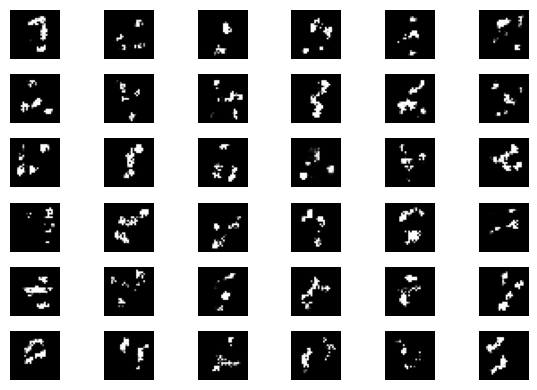

100 tensor(-0.3741, device='cuda:0', grad_fn=<SubBackward0>)
110 tensor(-0.3722, device='cuda:0', grad_fn=<SubBackward0>)
120 tensor(-0.3452, device='cuda:0', grad_fn=<SubBackward0>)
130 tensor(-0.3696, device='cuda:0', grad_fn=<SubBackward0>)
140 tensor(-0.3891, device='cuda:0', grad_fn=<SubBackward0>)
150 tensor(-0.3421, device='cuda:0', grad_fn=<SubBackward0>)
160 tensor(-0.3814, device='cuda:0', grad_fn=<SubBackward0>)
170 tensor(-0.3559, device='cuda:0', grad_fn=<SubBackward0>)
180 tensor(-0.3889, device='cuda:0', grad_fn=<SubBackward0>)
190 tensor(-0.3922, device='cuda:0', grad_fn=<SubBackward0>)


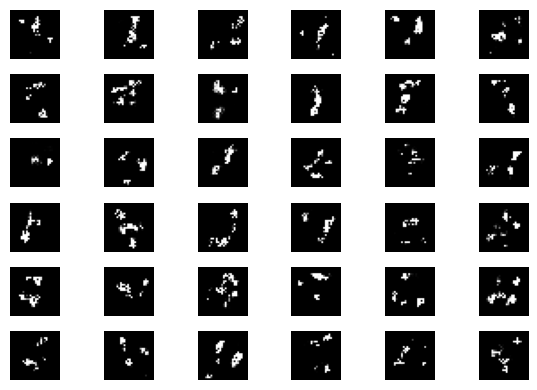

200 tensor(-0.2860, device='cuda:0', grad_fn=<SubBackward0>)
210 tensor(-0.3418, device='cuda:0', grad_fn=<SubBackward0>)
220 tensor(-0.4079, device='cuda:0', grad_fn=<SubBackward0>)
230 tensor(-0.3385, device='cuda:0', grad_fn=<SubBackward0>)
240 tensor(-0.3380, device='cuda:0', grad_fn=<SubBackward0>)
250 tensor(-0.3444, device='cuda:0', grad_fn=<SubBackward0>)
260 tensor(-0.3395, device='cuda:0', grad_fn=<SubBackward0>)
270 tensor(-0.4076, device='cuda:0', grad_fn=<SubBackward0>)
280 tensor(-0.4048, device='cuda:0', grad_fn=<SubBackward0>)
290 tensor(-0.3879, device='cuda:0', grad_fn=<SubBackward0>)


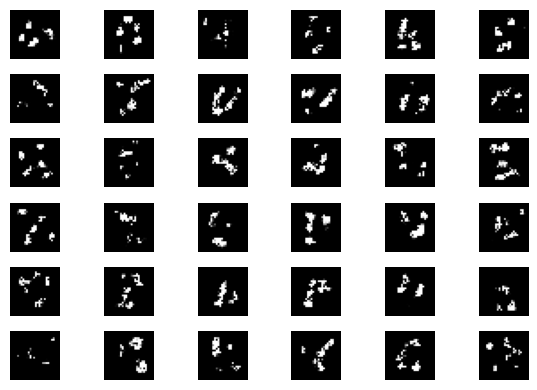

300 tensor(-0.3184, device='cuda:0', grad_fn=<SubBackward0>)
310 tensor(-0.3363, device='cuda:0', grad_fn=<SubBackward0>)
320 tensor(-0.3781, device='cuda:0', grad_fn=<SubBackward0>)
330 tensor(-0.4094, device='cuda:0', grad_fn=<SubBackward0>)
340 tensor(-0.3184, device='cuda:0', grad_fn=<SubBackward0>)
350 tensor(-0.3859, device='cuda:0', grad_fn=<SubBackward0>)
360 tensor(-0.3963, device='cuda:0', grad_fn=<SubBackward0>)
370 tensor(-0.3827, device='cuda:0', grad_fn=<SubBackward0>)
380 tensor(-0.3868, device='cuda:0', grad_fn=<SubBackward0>)
390 tensor(-0.3608, device='cuda:0', grad_fn=<SubBackward0>)


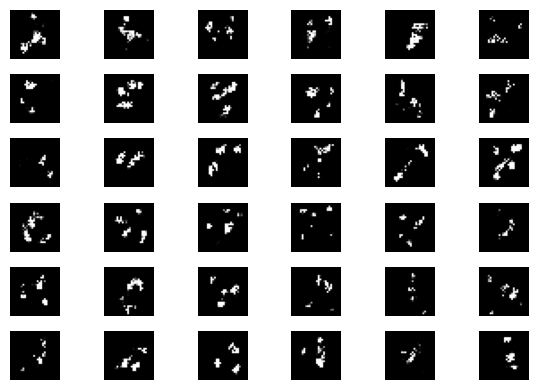

400 tensor(-0.4527, device='cuda:0', grad_fn=<SubBackward0>)
410 tensor(-0.1369, device='cuda:0', grad_fn=<SubBackward0>)
420 tensor(-0.3200, device='cuda:0', grad_fn=<SubBackward0>)
430 tensor(-0.4106, device='cuda:0', grad_fn=<SubBackward0>)
440 tensor(-0.3652, device='cuda:0', grad_fn=<SubBackward0>)
450 tensor(-0.4063, device='cuda:0', grad_fn=<SubBackward0>)
460 tensor(-0.3681, device='cuda:0', grad_fn=<SubBackward0>)
470 tensor(-0.4284, device='cuda:0', grad_fn=<SubBackward0>)
480 tensor(-0.3889, device='cuda:0', grad_fn=<SubBackward0>)
490 tensor(-0.3896, device='cuda:0', grad_fn=<SubBackward0>)


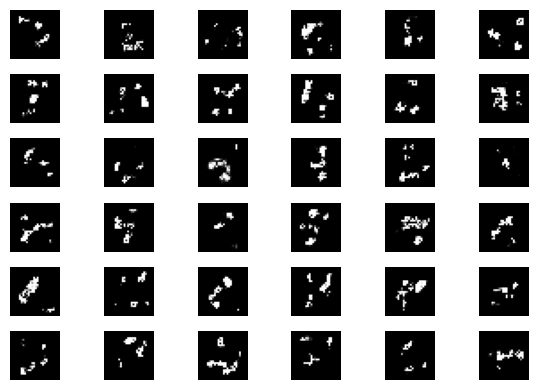

500 tensor(-0.3848, device='cuda:0', grad_fn=<SubBackward0>)
510 tensor(-0.4228, device='cuda:0', grad_fn=<SubBackward0>)
520 tensor(-0.3421, device='cuda:0', grad_fn=<SubBackward0>)
530 tensor(-0.4233, device='cuda:0', grad_fn=<SubBackward0>)
540 tensor(-0.4490, device='cuda:0', grad_fn=<SubBackward0>)
550 tensor(-0.4184, device='cuda:0', grad_fn=<SubBackward0>)
560 tensor(-0.3729, device='cuda:0', grad_fn=<SubBackward0>)
570 tensor(-0.4453, device='cuda:0', grad_fn=<SubBackward0>)
580 tensor(-0.3602, device='cuda:0', grad_fn=<SubBackward0>)
590 tensor(-0.4099, device='cuda:0', grad_fn=<SubBackward0>)


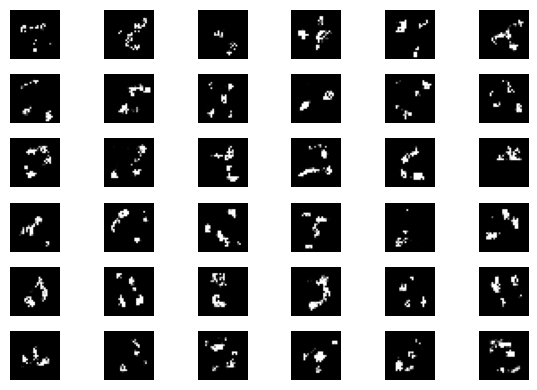

600 tensor(-0.3744, device='cuda:0', grad_fn=<SubBackward0>)
610 tensor(-0.4250, device='cuda:0', grad_fn=<SubBackward0>)
620 tensor(-0.4937, device='cuda:0', grad_fn=<SubBackward0>)
630 tensor(-0.4276, device='cuda:0', grad_fn=<SubBackward0>)
640 tensor(-0.3884, device='cuda:0', grad_fn=<SubBackward0>)
650 tensor(-0.4175, device='cuda:0', grad_fn=<SubBackward0>)
660 tensor(-0.3291, device='cuda:0', grad_fn=<SubBackward0>)
670 tensor(-0.4113, device='cuda:0', grad_fn=<SubBackward0>)
680 tensor(-0.3632, device='cuda:0', grad_fn=<SubBackward0>)
690 tensor(-0.3925, device='cuda:0', grad_fn=<SubBackward0>)


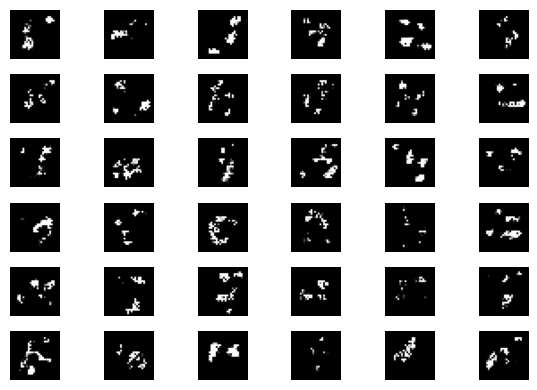

700 tensor(-0.3592, device='cuda:0', grad_fn=<SubBackward0>)
710 tensor(-0.4446, device='cuda:0', grad_fn=<SubBackward0>)
720 tensor(-0.4407, device='cuda:0', grad_fn=<SubBackward0>)
730 tensor(-0.4237, device='cuda:0', grad_fn=<SubBackward0>)
740 tensor(-0.4462, device='cuda:0', grad_fn=<SubBackward0>)
750 tensor(-0.4193, device='cuda:0', grad_fn=<SubBackward0>)
760 tensor(-0.4822, device='cuda:0', grad_fn=<SubBackward0>)
770 tensor(-0.4018, device='cuda:0', grad_fn=<SubBackward0>)
780 tensor(-0.4526, device='cuda:0', grad_fn=<SubBackward0>)
790 tensor(-0.4088, device='cuda:0', grad_fn=<SubBackward0>)


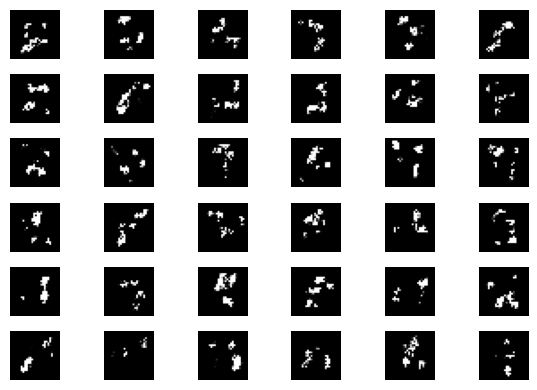

800 tensor(-0.4361, device='cuda:0', grad_fn=<SubBackward0>)
810 tensor(-0.2646, device='cuda:0', grad_fn=<SubBackward0>)
820 tensor(-0.3911, device='cuda:0', grad_fn=<SubBackward0>)
830 tensor(-0.4602, device='cuda:0', grad_fn=<SubBackward0>)
840 tensor(-0.4024, device='cuda:0', grad_fn=<SubBackward0>)
850 tensor(-0.4248, device='cuda:0', grad_fn=<SubBackward0>)
860 tensor(-0.4226, device='cuda:0', grad_fn=<SubBackward0>)
870 tensor(-0.4684, device='cuda:0', grad_fn=<SubBackward0>)
880 tensor(-0.4242, device='cuda:0', grad_fn=<SubBackward0>)
890 tensor(-0.4765, device='cuda:0', grad_fn=<SubBackward0>)


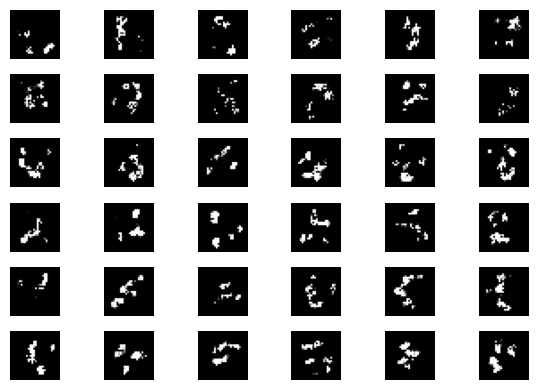

900 tensor(-0.4399, device='cuda:0', grad_fn=<SubBackward0>)
910 tensor(-0.4279, device='cuda:0', grad_fn=<SubBackward0>)
920 tensor(-0.4511, device='cuda:0', grad_fn=<SubBackward0>)
930 tensor(-0.4689, device='cuda:0', grad_fn=<SubBackward0>)


In [ ]:
num_iter = 4000
batch_size = 256

# for visualization
num_rows = 6
num_cols = 6
temp_rand_seed = torch.randn(num_rows*num_cols,16,7,7).to(device)

for itr in range(num_iter) :
  rand_idx = np.random.randint(0, len(x_train), batch_size)
  temp_x = torch.as_tensor(x_train[rand_idx]).float().to(device)
  z_now, log_det_now = model(temp_x)
  loss_z = torch.mean(z_now**2)
  loss = loss_z - log_det_now/4

  optim.zero_grad()
  loss.backward()
  optim.step()

  if itr % 10 == 0 :
    print(itr, loss)

  if itr % 100 == 99 :
    temp_rand_seed = torch.randn(num_rows*num_cols,16,7,7).to(device)
    images = model.inverse_forward(temp_rand_seed)
    images = [img.detach().cpu().numpy().reshape(28,28) for img in images]
    display_images_grid(images, num_rows, num_cols)


In [ ]:
rand_idx = np.random.randint(0, len(x_train), batch_size)
temp_x = torch.as_tensor(x_train[rand_idx]).float().to(device)
temp_output, log_det_now = model(temp_x)
temp_inv = model.inverse_forward(temp_output)

print(torch.mean(temp_output**2)) # 6.4187 -> 3.3105
print(-log_det_now/4) # -48.1693 -> -51.9723
print(torch.mean(abs(temp_inv - temp_x)))

tensor(0.2233, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6016, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1912e-06, device='cuda:0', grad_fn=<MeanBackward0>)


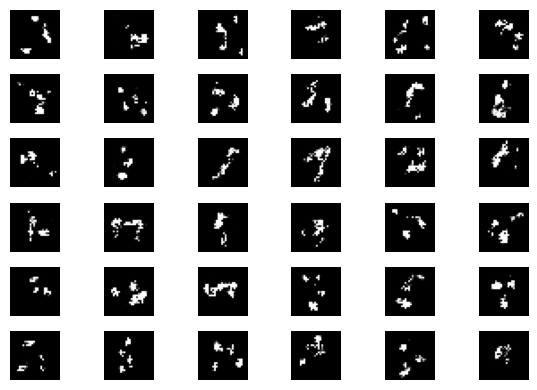

In [ ]:
num_rows = 6
num_cols = 6
all_images = []
temp_inv = model.inverse_forward(torch.randn(num_rows*num_cols,16,7,7).to(device))
temp_inv = [img.detach().cpu().numpy().reshape(28,28) for img in temp_inv]
display_images_grid(temp_inv, num_rows, num_cols)
